In [41]:
#Loading Graph Data
import json
import pandas as pd
import networkx as nx
import os


def load_graph_from_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    G = nx.Graph([(edge['source'], edge['target']) for edge in data['edges']])
    return G

def load_graph_from_csv(file_path):
    df = pd.read_csv(file_path)
    G = nx.from_pandas_edgelist(df, 'source', 'target')
    return G

def load_graph_from_txt(file_path):
    G = nx.read_edgelist(file_path, nodetype=int) 
    return G

def load_graph(file_path):
    _, file_extension = os.path.splitext(file_path)

    if file_extension.lower() == '.json':
        return load_graph_from_json(file_path)
    elif file_extension.lower() == '.csv':
        return load_graph_from_csv(file_path)
    elif file_extension.lower() == '.txt':
        return load_graph_from_txt(file_path)
    else:
        raise ValueError("Unsupported file format")

file_path = "D:\\DBMSP\\Graphs\\2KCS_graph.txt" 
G = load_graph(file_path)
unassigned = set(G.nodes())
assigned = set()



In [42]:


# Find the number of nodes
num_nodes = G.number_of_nodes()
print(f"Number of nodes in the graph: {num_nodes}")

# Find the number of edges
num_edges = G.number_of_edges()
print(f"Number of edges in the graph: {num_edges}")


Number of nodes in the graph: 1869
Number of edges in the graph: 5477


In [43]:
import networkx as nx
import random
from collections import Counter
import matplotlib.pyplot as plt
import time
def is_subgraph_connected(G, nodes):
   #Checks if unassigned/assigned areas are contiguous
    if not nodes:  
        return False
    subgraph = G.subgraph(nodes)
    return nx.is_connected(subgraph)

#Growing phase
def grow_partitions(G, partitions, sizes, unassigned, assigned):
    for i in range(len(sizes)):
        if not unassigned:
            break  # Stop if no unassigned nodes left
        seed = random.choice(list(unassigned))
        queue = [seed]
        while queue and len(partitions[i]) < sizes[i]:
            node = queue.pop(0)
            if node in unassigned:
                partitions[i].add(node)
                assigned.add(node)
                unassigned.remove(node)
                neighbors = [n for n in G.neighbors(node) if n in unassigned and n not in queue]
                queue.extend(neighbors)
    return partitions
#Merging Phase
def merge_isolated_nodes(G, partitions, unassigned, assigned):
    components = list(nx.connected_components(G.subgraph(unassigned)))
    if len(components) <= 1:
        return partitions

    for component in components:
        neighbor_partitions = []
        for node in component:
            neighbors = set(G.neighbors(node))
            for neighbor in neighbors:
                if neighbor in assigned:
                    for part_id, part_nodes in partitions.items():
                        if neighbor in part_nodes:
                            neighbor_partitions.append(part_id)
                            break

        if neighbor_partitions:
            common_partition = Counter(neighbor_partitions).most_common(1)[0][0]
            for node in component:
                partitions[common_partition].add(node)
                assigned.add(node)
                unassigned.remove(node)
    return partitions
#Splitting Phase
def split_partitions(G, partitions, sizes):
    for part_id, nodes in partitions.items():
        if len(nodes) > sizes[part_id]:
            excess = len(nodes) - sizes[part_id]
            internal_degrees = {node: len([n for n in G.neighbors(node) if n in nodes]) for node in nodes}
            sorted_nodes = sorted(nodes, key=lambda n: internal_degrees[n])
            for _ in range(excess):
                node_to_remove = sorted_nodes.pop(0)
                partitions[part_id].remove(node_to_remove)
    return partitions
#Set number of retries
def partition_graph_with_retries(G, k, sizes, max_retries=10000):
    start_time = time.time()
    retry_count = 0
    success = False
    contiguity_check_passed = False

    while retry_count < max_retries and not (success and contiguity_check_passed):
        partitions = {i: set() for i in range(k)}
        unassigned = set(G.nodes())
        assigned = set()
        
        grow_partitions(G, partitions, sizes, unassigned, assigned)
        merge_isolated_nodes(G, partitions, unassigned, assigned)
        split_partitions(G, partitions, sizes)
        
        success = all(len(partitions[i]) == sizes[i] for i in range(k))
        contiguity_check_passed = is_subgraph_connected(G, unassigned) or not unassigned
        
        if not (success and contiguity_check_passed):
            retry_count += 1
        else:
            print("Success: Partition sizes are met and unassigned area is contiguous.")
            end_time = time.time()
            runtime_seconds = end_time - start_time
            print(f"Runtime: {runtime_seconds} seconds")
    
    if not (success and contiguity_check_passed):
        print("Failed to meet partition sizes or unassigned area not contiguous after maximum retries.")
        
        
    return partitions

#G = nx.erdos_renyi_graph(10, 0.2)

k = 3  # Number of partitions
sizes = [500, 200, 1169]  # Target sizes for each partition

partitions = partition_graph_with_retries(G, k, sizes)

for part_id, nodes in partitions.items():
    print(f"Partition {part_id} size: {len(nodes)}")

Success: Partition sizes are met and unassigned area is contiguous.
Runtime: 0.18605947494506836 seconds
Partition 0 size: 500
Partition 1 size: 200
Partition 2 size: 1169


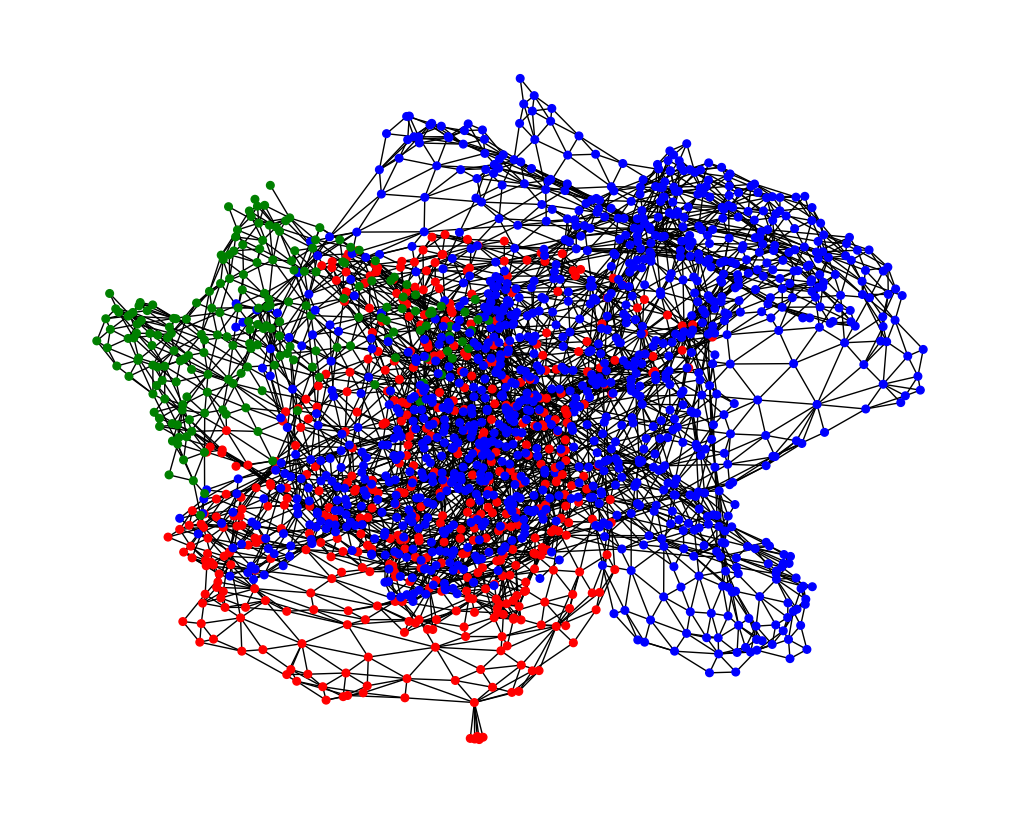

In [44]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_partitions(G, partitions):
    color_map = {}
    colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']
    
    for part_id, nodes in partitions.items():
        for node in nodes:
            color_map[node] = colors[part_id % len(colors)]
    
    default_color = 'grey'
    node_colors = [color_map.get(node, default_color) for node in G.nodes()]

    plt.figure(figsize=(10, 8))
    nx.draw(G, node_color=node_colors, with_labels=False, node_size=30, font_weight='bold', font_size=9)
    plt.show()

visualize_partitions(G, partitions)

